# Change the distribution in default MLE to improve the model

The default MLE uses Normal Distribution to model the distribution of residuals between Y and X, which might not be true.

After fitting the MLE on 4 data sets, we found some of them are not showing normality in residuals, which indicates the Normality assumption is not suitable.

Hence, we can improve the model prediction quality by using different distribution assumption. 

Additionaly, **we can assume other relationship between $\hat y$ and $X$** instead of the simple linearity to capture their numerical chaing relation more effectively.

In [72]:
library(ggplot2)
library(gridExtra)

In [1]:
# read the data
anscombe

x1,x2,x3,x4,y1,y2,y3,y4
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
10,10,10,8,8.04,9.14,7.46,6.58
8,8,8,8,6.95,8.14,6.77,5.76
13,13,13,8,7.58,8.74,12.74,7.71
9,9,9,8,8.81,8.77,7.11,8.84
11,11,11,8,8.33,9.26,7.81,8.47
14,14,14,8,9.96,8.10,8.84,7.04
6,6,6,8,7.24,6.13,6.08,5.25
4,4,4,19,4.26,3.10,5.39,12.50
12,12,12,8,10.84,9.13,8.15,5.56


In [11]:
# Define a likelihood function for the linear model with t-distribution 
# for residuals

log_likelihood_t <- function(params, X, y) {
    beta0 <- params[1]
    beta1 <- params[2]
    sigma <- params[3]
    nu <- params[4]
    
    y_hat <- beta0 + beta1 * X
    residuals <- y - y_hat
    
    # Log-likelihood for t-distribution
    ll <- sum(dt(residuals / sigma, df = nu, log = TRUE) - log(sigma))
    return(-ll)  # Return negative log-likelihood for minimization
}

In [25]:
# Define a likelihood function for the linear model with uniform distribution for residuals
log_likelihood_uniform <- function(params, X, y) {
    beta0 <- params[1]
    beta1 <- params[2]
    a <- params[3]
    b <- params[4]
    
    y_hat <- beta0 + beta1 * X
    residuals <- y - y_hat
    
    # Log-likelihood for uniform distribution
    ll <- sum(dunif(residuals, min = a, max = b, log = FALSE))
    return(-ll)  # Return negative log-likelihood for minimization
}

In [26]:
# Define a likelihood function for the linear model with gamma distribution for residuals
log_likelihood_gamma <- function(params, X, y) {
    beta0 <- params[1]
    beta1 <- params[2]
    shape <- params[3]
    scale <- params[4]
    
    y_hat <- beta0 + beta1 * X
    residuals <- y - y_hat
    
    # Log-likelihood for gamma distribution
    ll <- sum(dgamma(residuals, shape = shape, scale = scale, log = FALSE))
    return(-ll)  # Return negative log-likelihood for minimization
}

       beta0        beta1        sigma           nu 
3.000086e+00 5.000921e-01 1.118521e+00 2.370729e+04 
        beta0         beta1         shape         scale 
-0.1997038836  0.7170431766  1.5448568029  0.0009301488 
   beta0    beta1        a        b 
0.000000 1.000000 0.000001 1.240000 


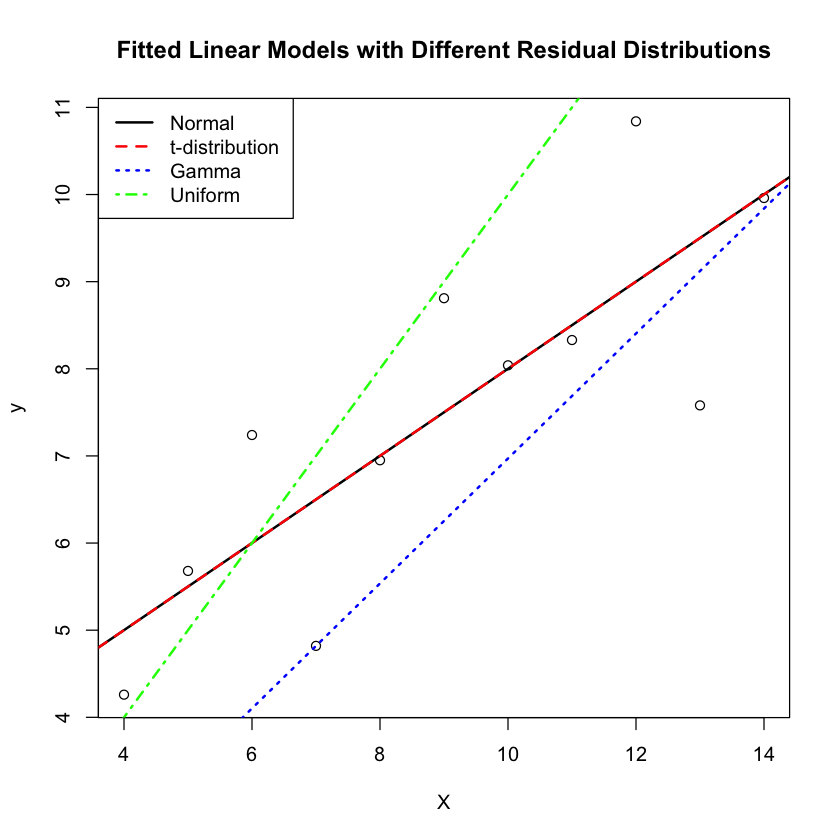

In [36]:
perform_mle <- function(X, y) {
    # Initial parameter estimates for t-distribution
    init_params_t <- c(beta0 = 0, beta1 = 1, sigma = 1, nu = 5)
    
    # Optimize the log-likelihood function for t-distribution
    fit_t <- optim(init_params_t, log_likelihood_t, X = X, y = y, method = "L-BFGS-B", 
                   lower = c(-Inf, -Inf, 1e-6, 2), upper = c(Inf, Inf, Inf, Inf))
    
    # Estimated parameters for t-distribution
    print(fit_t$par)
    
    # Initial parameter estimates for gamma distribution
    init_params_gamma <- c(beta0 = 0, beta1 = 1, shape = 2, scale = 1)
    
    # Optimize the log-likelihood function for gamma distribution
    fit_gamma <- optim(init_params_gamma, log_likelihood_gamma, X = X, y = y, method = "L-BFGS-B", 
                       lower = c(-Inf, -Inf, 1e-6, 1e-6), upper = c(Inf, Inf, Inf, Inf))
    
    # Estimated parameters for gamma distribution
    print(fit_gamma$par)
    
    # Ensure the initial parameters for uniform distribution are within the valid range
    init_params_unif <- c(beta0 = 0, beta1 = 1, a = min(y - (0 + 1 * X)), b = max(y - (0 + 1 * X)))
    
    # Optimize the log-likelihood function for uniform distribution
    fit_unif <- optim(init_params_unif, log_likelihood_uniform, X = X, y = y, method = "L-BFGS-B", 
                      lower = c(-Inf, -Inf, 1e-6, 1e-6), upper = c(Inf, Inf, 10, 10))
    
    # Estimated parameters for uniform distribution
    print(fit_unif$par)
    
    # Fit the default normal distribution model
    fit_default <- lm(y ~ X)
    
    # Calculate sigma (standard deviation of residuals) for the default model
    sigma_default <- sqrt(mean(fit_default$residuals^2))
    
    # Visualize the fitted results from the 4 models with different distributions
    plot(X, y, main = "Fitted Linear Models with Different Residual Distributions")
    abline(fit_default, col = "black", lty = 1, lwd = 2)
    abline(fit_t$par[1:2], col = "red", lty = 2, lwd = 2)
    abline(fit_gamma$par[1:2], col = "blue", lty = 3, lwd = 2)
    abline(fit_unif$par[1:2], col = "green", lty = 4, lwd = 2)
    legend("topleft", legend = c("Normal", "t-distribution", "Gamma", "Uniform"), 
           col = c("black", "red", "blue", "green"), lty = 1:4, lwd = 2)
    
    return(list(fit_default = fit_default, fit_t = fit_t, fit_gamma = fit_gamma, fit_unif = fit_unif))
}

# Example usage with anscombe dataset
X <- anscombe$x1
y <- anscombe$y1
results <- perform_mle(X, y)

In [47]:
names(results$fit_t)
results$fit_t$par

[1] "par"         "value"       "counts"      "convergence" "message"

beta0        beta1        sigma           nu 
3.000086e+00 5.000921e-01 1.118521e+00 2.370729e+04

       beta0        beta1        sigma           nu 
3.000086e+00 5.000921e-01 1.118521e+00 2.370729e+04 
        beta0         beta1         shape         scale 
-0.1997038836  0.7170431766  1.5448568029  0.0009301488 
   beta0    beta1        a        b 
0.000000 1.000000 0.000001 1.240000 
       beta0        beta1        sigma           nu 
3.002597e+00 4.998336e-01 1.119059e+00 2.313097e+04 
      beta0       beta1       shape       scale 
0.531269518 0.631152728 1.741346763 0.003521592 
  beta0   beta1       a       b 
0.0e+00 1.0e+00 1.0e-06 2.6e-01 


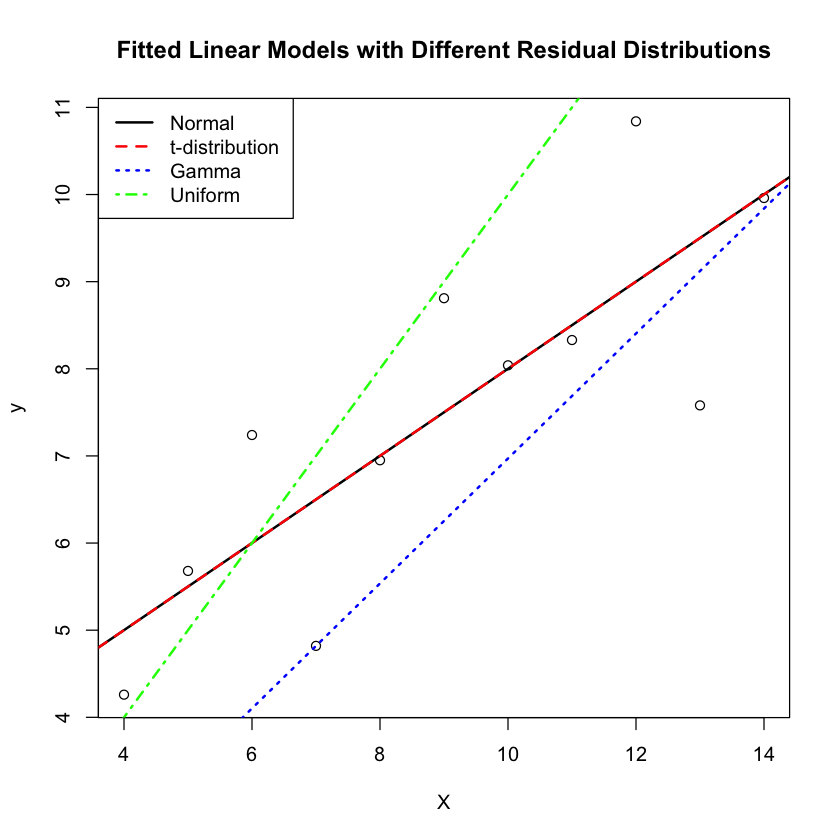

      beta0       beta1       sigma          nu 
4.007049312 0.345232573 0.004201211 5.250842914 
      beta0       beta1       shape       scale 
4.296797956 0.315264947 2.629125263 0.003953654 
   beta0    beta1        a        b 
0.000000 1.000000 0.000001 1.390000 


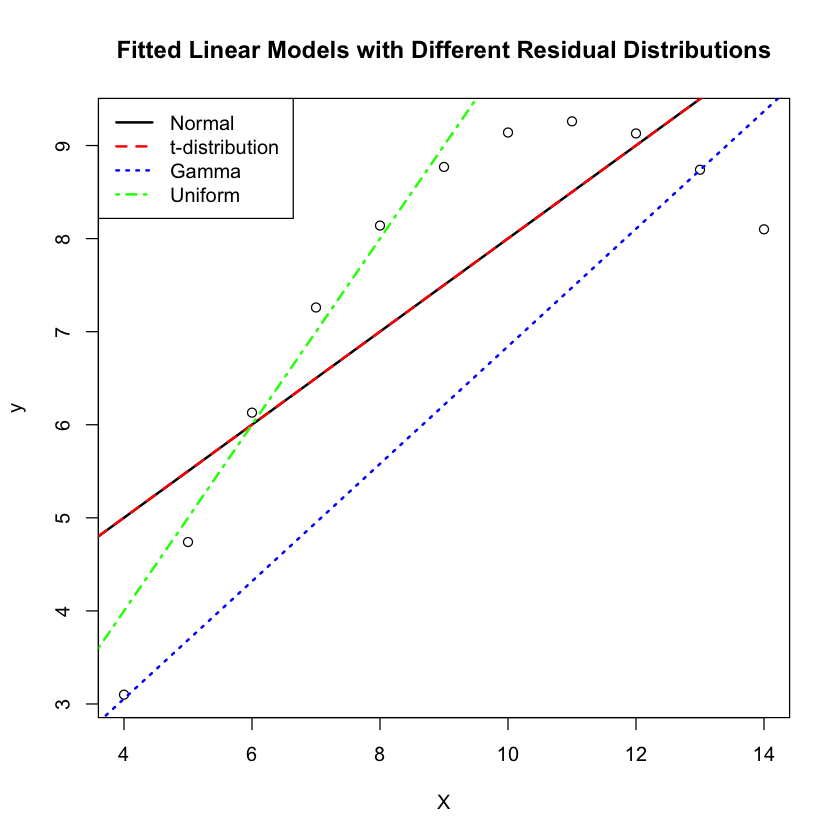

       beta0        beta1        sigma           nu 
3.001509e+00 4.999278e-01 1.117624e+00 2.314294e+04 
       beta0        beta1        shape        scale 
-0.015364097  0.862432386  1.582283377  0.003149105 
  beta0   beta1       a       b 
0.0e+00 1.0e+00 1.0e-06 8.4e-01 


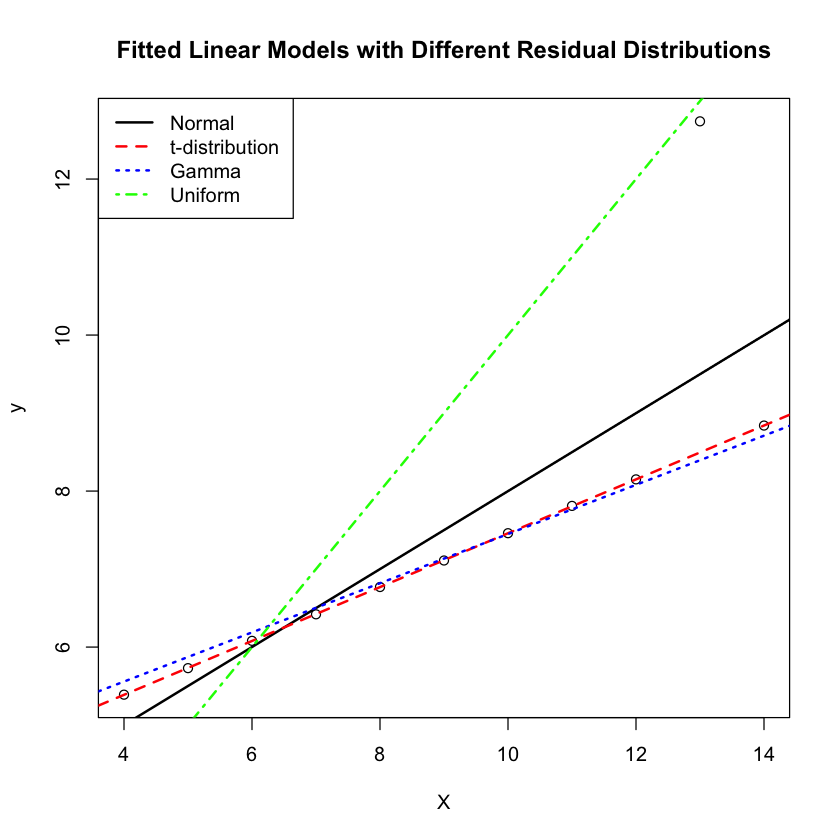

[1] "dataset1" "dataset2" "dataset3" "dataset4"

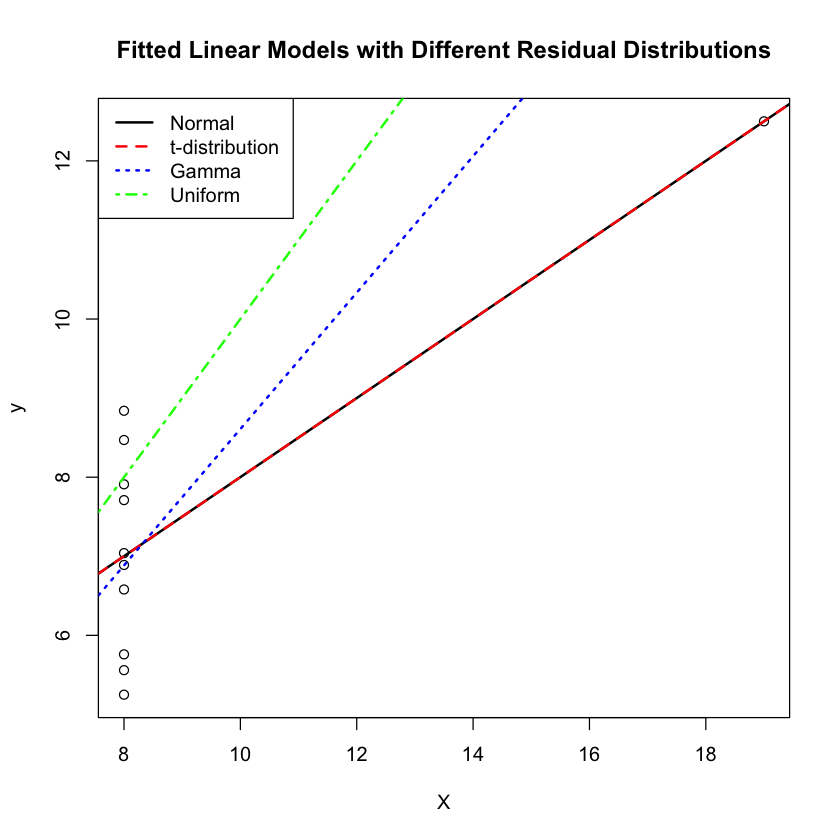

In [49]:
# Create a list to store the results for each dataset
results_list <- list()

# Perform MLE for each dataset and store the results
for (i in 1:4) {
    X <- anscombe[[paste0("x", i)]]
    y <- anscombe[[paste0("y", i)]]
    results_list[[paste0("dataset", i)]] <- perform_mle(X, y)
}

# Display the names of the results for verification
names(results_list)

In [88]:
# Function to visualize fitted values for each dataset
visualize_fitted_values <- function(results_list) {
    plots <- list()
    
    for (i in 1:4) {
        X <- anscombe[[paste0("x", i)]]
        y <- anscombe[[paste0("y", i)]]
        
        # Calculate fitted values for each model
        y_hat_default <- results_list[[paste0("dataset", i)]]$fit_default$fitted.values
        y_hat_t <- results_list[[paste0("dataset", i)]]$fit_t$par[1] + results_list[[paste0("dataset", i)]]$fit_t$par[2] * X
        y_hat_gamma <- results_list[[paste0("dataset", i)]]$fit_gamma$par[1] + results_list[[paste0("dataset", i)]]$fit_gamma$par[2] * X
        y_hat_unif <- results_list[[paste0("dataset", i)]]$fit_unif$par[1] + results_list[[paste0("dataset", i)]]$fit_unif$par[2] * X
        
        # Create a data frame for plotting
        plot_data <- data.frame(
            X = X,
            y = y,
            y_hat_default = y_hat_default,
            y_hat_t = y_hat_t,
            y_hat_gamma = y_hat_gamma,
            y_hat_unif = y_hat_unif
        )
        
        # Create the plot
        p <- ggplot(plot_data, aes(x = X, y = y)) +
            geom_point() +
            geom_line(aes(y = y_hat_default, color = "Normal")) +
            geom_line(aes(y = y_hat_t, color = "t-distribution")) +
            geom_line(aes(y = y_hat_gamma, color = "Gamma")) +
            geom_line(aes(y = y_hat_unif, color = "Uniform")) +
            labs(title = paste("Dataset", i), color = "Model")        
        plots[[i]] <- p
    }
    
    # Arrange the plots in a grid with the legend
    combined_plot <- plot_grid(
        plot_grid(plotlist = plots, ncol = 2))
}

# Visualize the fitted values
plot <- visualize_fitted_values(results_list)
# Save the combined plot to a file
ggsave("results/MLE_fitted_values_plot.png", plot, width = 12, height = 8)

In [80]:
# Organize the information from different datasets into a table
results_table <- data.frame(
    Dataset = c("Dataset 1", "Dataset 2", "Dataset 3", "Dataset 4"),
    Normal_Intercept = sapply(results_list, function(x) x$fit_default$coefficients[1]),
    Normal_Slope = sapply(results_list, function(x) x$fit_default$coefficients[2]),
    T_Intercept = sapply(results_list, function(x) x$fit_t$par[1]),
    T_Slope = sapply(results_list, function(x) x$fit_t$par[2]),
    Gamma_Intercept = sapply(results_list, function(x) x$fit_gamma$par[1]),
    Gamma_Slope = sapply(results_list, function(x) x$fit_gamma$par[2]),
    Uniform_Intercept = sapply(results_list, function(x) x$fit_unif$par[1]),
    Uniform_Slope = sapply(results_list, function(x) x$fit_unif$par[2])
)


In [66]:
calculate_r_squared <- function(y, y_hat) {
    ss_total <- sum((y - mean(y))^2)
    ss_res <- sum((y - y_hat)^2)
    r_squared <- 1 - (ss_res / ss_total)
    return(r_squared)
}

# Create a list to store the R-squared values for each dataset and model
r_squared_list <- list()

# Calculate R-squared for each dataset and model
for (i in 1:4) {
    X <- anscombe[[paste0("x", i)]]
    y <- anscombe[[paste0("y", i)]]
    
    # Calculate fitted values for each model
    y_hat_default <- results_list[[paste0("dataset", i)]]$fit_default$fitted.values
    y_hat_t <- results_list[[paste0("dataset", i)]]$fit_t$par[1] + results_list[[paste0("dataset", i)]]$fit_t$par[2] * X
    y_hat_gamma <- results_list[[paste0("dataset", i)]]$fit_gamma$par[1] + results_list[[paste0("dataset", i)]]$fit_gamma$par[2] * X
    y_hat_unif <- results_list[[paste0("dataset", i)]]$fit_unif$par[1] + results_list[[paste0("dataset", i)]]$fit_unif$par[2] * X
    
    # Calculate R-squared values
    r_squared_default <- calculate_r_squared(y, y_hat_default)
    r_squared_t <- calculate_r_squared(y, y_hat_t)
    r_squared_gamma <- calculate_r_squared(y, y_hat_gamma)
    r_squared_unif <- calculate_r_squared(y, y_hat_unif)
    
    # Store the R-squared values in the list
    r_squared_list[[paste0("dataset", i)]] <- c(
        Normal = r_squared_default,
        T_Distribution = r_squared_t,
        Gamma = r_squared_gamma,
        Uniform = r_squared_unif
    )
}

# Display the R-squared values for verification
print(r_squared_list)

$dataset1
        Normal T_Distribution          Gamma        Uniform 
     0.6665425      0.6665425      0.1265058     -0.5984589 

$dataset2
        Normal T_Distribution          Gamma        Uniform 
     0.6662420      0.6662420      0.1774297     -0.5988912 

$dataset3
        Normal T_Distribution          Gamma        Uniform 
     0.6663240      0.5629118      0.5398281     -0.6018018 

$dataset4
        Normal T_Distribution          Gamma        Uniform 
     0.6667073      0.6667073      0.3000023     -0.6000125 



# Do regression on the data set 2 with entended linear regression